In [14]:
from fastai.vision.all import *
#hide
from fastbook import *

In [15]:
path = Path("../data/usq")

In [16]:
#fnames = get_image_files(path/"images")
fnames = get_image_files(path/"mipimages")

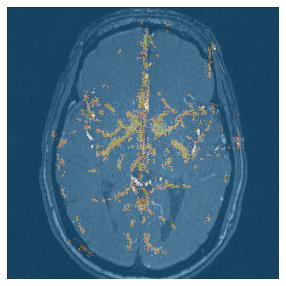

In [17]:
img = PILImage.create(fnames[0])
#mask = PILMask.create(str(fnames[0]).replace('images','masks'))
mask = PILMask.create(str(fnames[0]).replace('mipimages','mipmasks'))
ax = img.show()
ax = mask.show(ctx=ax)

In [8]:
tfm = Transform(aug_tfm)

In [9]:
class SegmentationAlbumentationsTransform(ItemTransform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

In [10]:
class SegmentationMaskTransform(ItemTransform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, x):
        img,mask = x
        
        mask = (mask > self._gt_pxl_threshold).astype(int) 
        mask = (mask * 255)
        
        
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

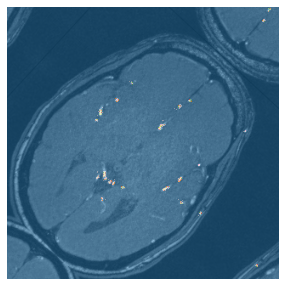

In [14]:
tfm = SegmentationAlbumentationsTransform(ShiftScaleRotate(p=1))
a,b = tfm((img, mask))
ax = a.show()
ax = b.show(ctx=ax)

### Try DataBlock

In [ ]:
aug = ShiftScaleRotate(p=1)
def aug_tfm(img): 
    np_img = np.array(img)
    aug_img = aug(image=np_img)['image']
    return PILImage.create(aug_img)

In [4]:
def get_msk(fname):
    "Grab a mask from a `filename` and adjust the pixels based on `pix2class`"
    fn = str(fname).replace('images','masks')
    msk = np.array(PILMask.create(fn))
    msk = (msk > 100)
    msk = (msk * 1).astype(np.uint8)
    return PILMask.create(msk)

In [5]:
codes = ['Background', 'CV']

In [6]:
get_y = lambda o: get_msk(o)

In [7]:
binary = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   item_tfms=Resize(224),
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [8]:
dls = binary.dataloaders(path, bs=8)

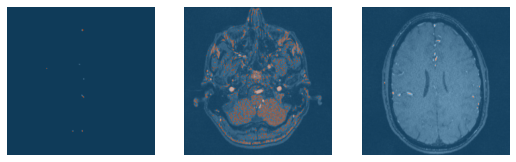

In [9]:
dls.show_batch(nrows=1, ncols=3)
#dls.show_batch(max_n=4,  figsize=(14,10))

In [13]:
x, y = dls.one_batch()

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


SuggestedLRs(valley=tensor(4.3652e-05))

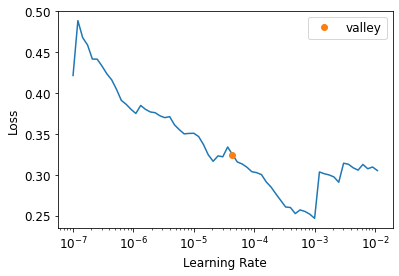

In [13]:
# fit with dice
learn = unet_learner(dls, resnet34, CrossEntropyLossFlat(axis=1), metrics=[Dice()])
learn.lr_find()
#learn.fit_one_cycle(3, 3e-3)

In [15]:
learn.unfreeze()

SuggestedLRs(valley=tensor(2.0893e-05))

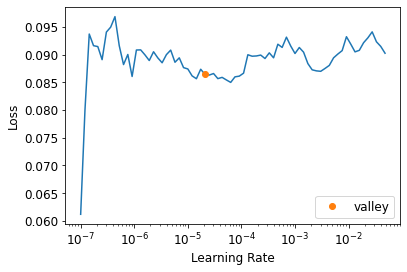

In [16]:
learn.lr_find()

In [43]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
#learn = unet_learner(dls, resnet34, CrossEntropyLossFlat(axis=1), metrics=[Dice()])
#learn = unet_learner(dls, resnet34, CrossEntropyLossFlat(axis=1), metrics=[dice])
#learn = unet_learner(dls, resnet34, Dice(axis=1), metrics=[foreground_acc])
learn = unet_learner(dls, resnet34, Dice(), metrics=[foreground_acc])
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,2.0893e-05))

In [14]:
#learn = unet_learner(dls, resnet34, CrossEntropyLossFlat(axis=1), metrics=[Dice()])
#learn = unet_learner(dls, resnet34, CrossEntropyLossFlat(axis=1), metrics=[dice])
#learn = unet_learner(dls, resnet34, Dice(axis=1), metrics=[foreground_acc])
learn = unet_learner(dls, resnet34, Dice(), metrics=[foreground_acc])
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,2.0893e-05))

epoch,train_loss,valid_loss,foreground_acc,time
0,0.136257,0.095522,0.069354,02:54
1,0.090385,0.091954,0.235358,02:54
2,0.098901,0.091501,0.226622,02:54


epoch,train_loss,valid_loss,foreground_acc,time
0,0.088931,0.091505,0.226311,03:12
1,0.098501,0.091486,0.232860,03:12
2,0.086805,0.091475,0.239211,03:12
3,0.099502,0.091463,0.239553,03:12
4,0.092853,0.091456,0.237015,03:12
5,0.093269,0.091457,0.235664,03:12
6,0.095934,0.091447,0.234435,03:12
7,0.087297,0.091442,0.235531,03:12
8,0.088736,0.091449,0.233821,03:13
9,0.097943,0.091439,0.233724,03:13


SuggestedLRs(valley=tensor(0.0008))

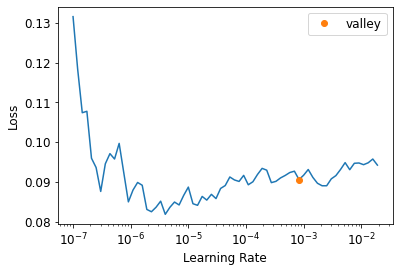

In [46]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(12, lr_max=slice(1e-6,0.0008))

epoch,train_loss,valid_loss,foreground_acc,time
0,0.087631,0.091565,0.216499,03:11
1,0.095145,0.091497,0.236186,03:11
2,0.094687,0.091485,0.204293,03:11
3,0.103532,0.091458,0.222125,03:11
4,0.094592,0.091381,0.240338,03:11
5,0.085047,0.091296,0.300759,03:11
6,0.093561,0.091506,0.237715,03:11
7,0.091786,0.091688,0.217950,03:11
8,0.093561,0.091213,0.312289,03:11
9,0.092748,0.091632,0.240161,03:11


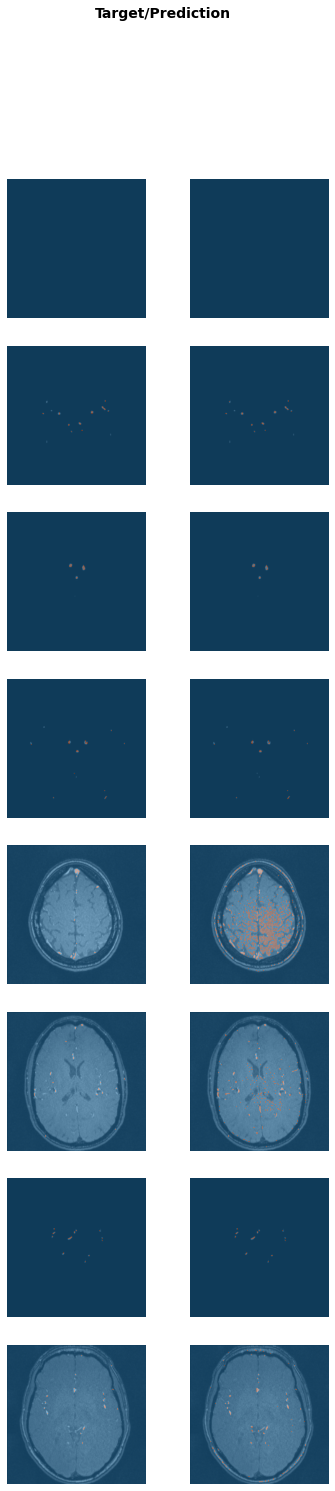

In [45]:
learn.show_results()

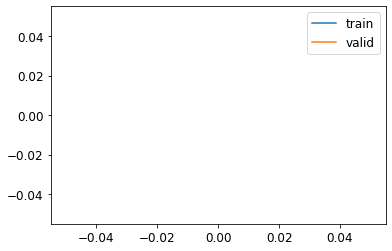

In [42]:
learn.recorder.plot_loss()

In [35]:
# fit with dice and CELF
learn = unet_learner(dls, resnet34, CrossEntropyLossFlat(axis=1), metrics=[Dice()])
learn.fit(2)

epoch,train_loss,valid_loss,dice,time
0,0.100404,0.094063,0.427507,02:53
1,0.089258,0.091780,0.147284,02:53


In [1]:
# learn = unet_learner(dls=dls, arch=resnet34, loss_func=CrossEntropyLossFlat(axis=1), metrics=[Dice(),JaccardCoeff()],wd=1e-2,
#                      pretrained=True,normalize=True).to_fp16()

In [36]:
learn = unet_learner(dls, resnet34, CrossEntropyLossFlat(axis=1), metrics=foreground_acc)

In [37]:
# fit with just dice
learn.fit(2)

epoch,train_loss,valid_loss,foreground_acc,time
0,0.091643,0.093102,0.359387,02:53
1,0.095237,0.092683,0.154164,02:53


SuggestedLRs(valley=tensor(1.0000e-05))

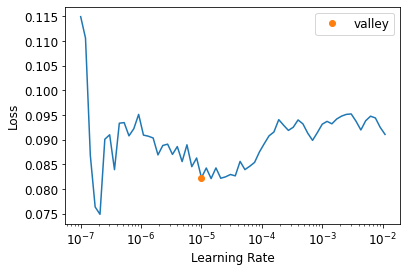

In [13]:
learn.lr_find()

In [14]:
#learn = unet_learner(dls, resnet34)#, metrics=error_rate)
learn.fine_tune(2, base_lr=1.0000e-05)

epoch,train_loss,valid_loss,dice,time
0,0.090431,0.091488,0.471011,02:54


epoch,train_loss,valid_loss,dice,time
0,0.094773,0.091458,0.455914,03:12
1,0.094042,0.091446,0.446163,03:12


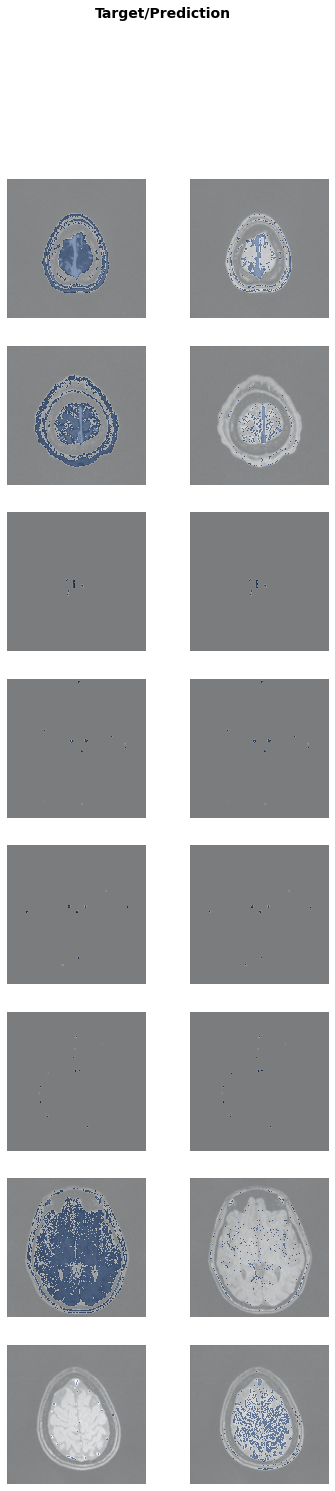

In [44]:
learn.show_results(cmap='Blues', vmin=0, vmax=1)

In [45]:
preds = learn.get_preds()

In [46]:
p = preds[0][0]

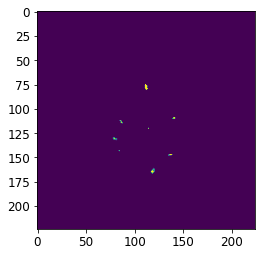

In [47]:
plt.imshow(p[1])

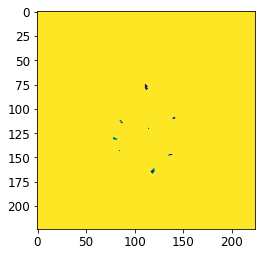

In [48]:
plt.imshow(p[0])

### Read in DatasetLoader

In [23]:
def label_func(fname:Path): return str(fname).replace('images','masks')

In [24]:
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = fnames, label_func = label_func
)

In [ ]:
dls.show_batch(max_n=6)

### Train UNet

In [52]:
#learn = unet_learner(dls, resnet34, n_out = 1)
learn = unet_learner(dls, resnet34, n_out=1, loss_func = BCEWithLogitsLossFlat())
learn.fine_tune(6)

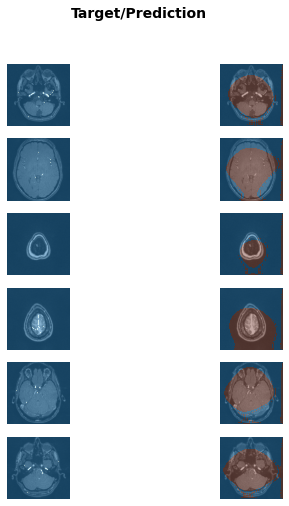

In [55]:
learn.show_results(max_n=6, figsize=(7,8))

In [56]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=3)

### Try Dense UNet

In [1]:
from fastai.vision.all import *
#hide
from fastbook import *

In [2]:
path = Path("../data/usq")

In [3]:
fnames = get_image_files(path/"images")

In [4]:
codes = {"background" : 0, "artery" : 255}

In [5]:
class MRAMask(Transform):
    def encodes(self, fn):
        mask = array(Image.open(fn))
        mask = (mask > 100).astype(int) 
        mask = (mask * 255).astype(np.uint8)
        return PILMask.create(mask)

In [6]:
def MRAMaskBlock(codes=None):
    return TransformBlock(type_tfms=MRAMask, item_tfms=AddMaskCodes(codes = codes), batch_tfms=IntToFloatTensor)

In [7]:
dblock = DataBlock(blocks=(ImageBlock, MRAMaskBlock(codes=list(codes.keys()))),
            splitter=RandomSplitter(),
            get_y = lambda o: str(o).replace('images','masks'),
            batch_tfms=aug_transforms())



In [8]:
dls = dblock.dataloaders(fnames, bs=16)

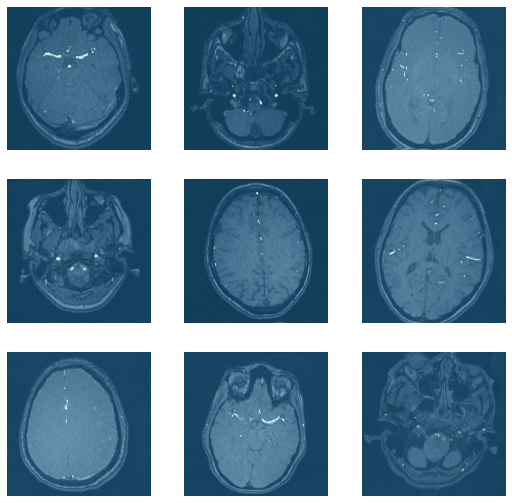

In [29]:
dls.show_batch()

In [10]:
#from fastai import *
from dynamic_unet.base import *

2021-08-16 13:18:03,292 util_log.py[147] INFO Start the program at:msdsvm, 10.0.0.4, with:Load module


Adjust wk folder for notebook failed


In [29]:
from fastai.vision.models import resnet34
m = resnet34()
m = nn.Sequential(*list(m.children())[:-2])
tst = DynamicUnet(m, 5, (128,128), norm_type=None)
x = cast(torch.randn(2, 3, 128, 128), TensorImage)
y = tst(x)
test_eq(y.shape, [2, 5, 128, 128])

In [16]:
encoder = nn.Sequential(*list(models.densenet121().children())[0])
unet = DynamicUnet(encoder, img_size=(224, 224), blur=False, blur_final=False,
                    self_attention=False, y_range=None, norm_type=NormType,
                    last_cross=True, n_out = 1,
                    bottle=False)
print(unet(torch.rand(1,3,224,224)).shape)

torch.Size([1, 1, 224, 224])


In [19]:
unet = unet.cuda(0)

In [70]:
def dice_loss(logits, target):
    logits = torch.sigmoid(logits)
    smooth = 1.0

    iflat = logits.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, logits, target):
        logits = logits.squeeze(1)
        if not (target.size() == logits.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), logits.size()))

        max_val = (-logits).clamp(min=0)
        loss = logits - logits * target + max_val + \
            ((-max_val).exp() + (-logits - max_val).exp()).log()

        invprobs = F.logsigmoid(-logits * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

class BCELoss2D(nn.Module):
    def __init__(self):
        super(BCELoss2D, self).__init__()
        
    def forward(self, logits, targets):
        logits = logits.squeeze(1)
        logits = F.sigmoid(logits)
        return F.binary_cross_entropy(logits, targets)

class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

class UpsampleModel():
    def __init__(self, model, cut_lr, name='upsample'):
        self.model,self.name, self.cut_lr = model, name, cut_lr

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.encoder), [self.cut_lr]))
        return lgs + [children(self.model)[1:]]

In [28]:
models = UpsampleModel(unet, cut_lr=20)
learn = cnn_learner(dls, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice, soft_jaccard]

TypeError: 'UpsampleModel' object is not callable

In [8]:
## Walkwithfastai.com

In [4]:
from fastai.vision.all import *

In [5]:
from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish
from fastai.losses import BaseLoss
from fastai.optimizer import ranger

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

from PIL import Image
import numpy as np

from torch import nn
from torchvision.models.resnet import resnet34

import torch
import torch.nn.functional as F

In [6]:
path = Path("../data/usq")

In [7]:
fnames = get_image_files(path/"images")

In [8]:
codes = {"background" : 0, "artery" : 255}

In [9]:
class MRAMask(Transform):
    def encodes(self, fn):
        mask = array(Image.open(fn))
        mask = (mask > 100).astype(int) 
        mask = (mask * 255).astype(np.uint8)
        return PILMask.create(mask)

In [10]:
def MRAMaskBlock(codes=None):
    return TransformBlock(type_tfms=MRAMask, item_tfms=AddMaskCodes(codes = codes), batch_tfms=IntToFloatTensor)

In [11]:
dblock = DataBlock(blocks=(ImageBlock, MRAMaskBlock(codes=list(codes.keys()))),
            splitter=RandomSplitter(),
            get_y = lambda o: str(o).replace('images','masks'),
            batch_tfms=aug_transforms())

In [12]:
dls = dblock.dataloaders(fnames, bs=16)

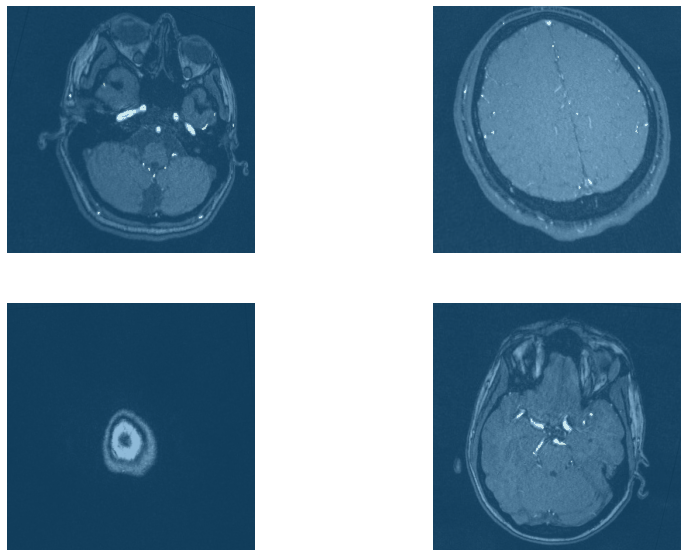

In [13]:
dls.show_batch(max_n=4, figsize=(14,10))

In [20]:
def acc_mra(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [21]:
opt = ranger

In [22]:
learn = unet_learner(dls, resnet34, metrics=acc_mra, self_attention=True, act_cls=Mish, opt_func=opt, loss_func = nn.CrossEntropyLoss()) #BCEWithLogitsLossFlat())

In [23]:
learn.summary()

DynamicUnet (Input shape: 16)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 64 x 160 x 160 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                     

In [25]:
# look at single activation
x,y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

torch.Size([16, 2, 320, 320])